# Clusters: Creating Color-Magnitude Diagrams

## Background
Clusters are groups of stars that are born at the same time. We can plot these stars in *Color vs. Magnitude*, where Color is a difference in the brightness between filters (say, B-V) and Magnitude is the brightness in one filter. This is known as a Color-Magnitude diagram, or a CMD. In this diagram, hotter stars, which are bluer, lie to the left; cooler stars, which are redder, lie to the right. 

You'll notice that there is a line of stars that form something called the Main Sequence. As a star ages, it begins to fuse more and more of its hydrogen fuel in order to shine; stars that are actively burning hydrogen in their cores fall on the Main Sequence. 

But, once a star uses up its hydrogen fuel, it evolves off the Main Sequence. When we look at a cluster with, many follow the Main-Sequence turnoff and evolve to become giants, which burn heavier elements in their cores. Brighter and more massive stars burn through their hydrogen fuel faster, while smaller stars burn their fuel more slowly. For this reason, more massive stars will turn off the main sequence faster and we can use the turnoff to measure the age of a cluster. 

### By the end of this project, you will be able to explain:
- the lifecycle of stars
- Hertzberg-Russel (HR) and Color-Magnitude diagrams (CMD)
- clusters and their ages


![image](hrdiagram.png)

Credit: eso.org

## Learning Questions
Please watch the following videos and answer these questions below.
- Main Sequence and the lifetime of stars: https://www.youtube.com/watch?v=ld75W1dz-h0
- Star clusters: https://www.youtube.com/watch?v=an4rgJ3O21A

### Q1. What is the main sequence?

### Q2. Why are bluer stars hotter and redder stars cooler?

### Q3. What is the difference between an open and globular cluster?

### Q4. What kind of stars live the longest on the main-sequence?

### Q5. What can the main-sequence turnoff tell us about the age of a cluster?

## Project: Creating a Color-Magnitude Diagram
You will create your own color-magnitude diagram (CMD) of a globular cluster and estimate the mass of the stars at its main sequence turnoff. 

## Imports

In [6]:
# for reduction
from astropy.io import fits 
import reduction
import matplotlib.pyplot as plt
import numpy as np
import shutil
import glob

# for cluster analysis
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder

## Data Summary

### You can either:
- Use data from this year (two filters, see the observing log for more info) *or*
- Use data from Nickel (2014-06-05) of two globular clusters:
    -  bias frames - frames 1-10 
    -  V flats - frames 41-45
    -  I flats - frames 51-55
    -  M92 - frames 85-86 (V, I)
    -  M15 - frames 76-77 (V, I)

If you want to use data from this year, you will need to instead grab data from the 'data_reduction_activity/data-2023-06-27-nickel' directory. Let me know if you want to do this instead.

## Data Reduction
Before we can use our data for science, we need to reduce it properly, just as we did in the reduction activity. You will be guided through the following steps:
- performing an overscan subtraction
- performing bias subtraction
- performing flat-fielding
- performing bad-pixel correction

### 1. Overscan Subtraction
An overscan region of the CCD chip that is not exposed to light. The overscan region keeps track of the *bias* level throughout the night; as a reminder, the *bias* is a zero second exposure which tells us how "bright" each pixel is without any light hitting the camera. For this reason, the overscan region it is a useful way to remove small variations in the bias level throughout the night. We must first remove these columns and apply an overscan subtraction before we begin on data reduction.

In [2]:
source_dir = './data/raw/'
files = source_dir + '*.fits'

reduction.overscan_subtraction(files)

### 2. Move files to correct directories
Having our overscan subtracted data, we can move our files to the correct directories for data reduction. In the data-2023-06-27-nickel directory, you should see a few different folders: 
- calibration, containing a folder named bias, halpha_flat, r_flat, and v_flat; this folder will store our calibration files.
- raw; this folder stores our raw files + overscan subtracted
- science

In this step, we will use the log and move each file into the correct folder.

In [178]:
bias_frames = range() # your bias files here
v_flat_frames = range()  # your v flat files here
i_flat_frames = range() # your i flat files here

science_frames = range() # your science frames here

# now we tell it where each of these files live and their names
v_flat_files = ['{0}d{1}_os.fits'.format(source_dir, num) for num in v_flat_frames]
i_flat_files = ['{0}d{1}_os.fits'.format(source_dir, num) for num in i_flat_frames]
bias_files = ['{0}d{1}_os.fits'.format(source_dir, num) for num in bias_frames]
science_files = ['{0}d{1}_os.fits'.format(source_dir, num) for num in science_frames]

# move over each of the files as defined above to a calibration directory for each of them
for file in v_flat_files:
    shutil.copy2(file, './data/calibration/v_flat')

for file in i_flat_files:
    shutil.copy2(file, './data/calibration/i_flat')

for file in bias_files:
    shutil.copy2(file, './data/calibration/bias')

for file in science_files:
    shutil.copy2(file, './data/science')


### 3. Create master bias
As we said before, the *bias* is a zero second exposure that characterizes the behavoir of our detector when it's not exposed to light; each pixel will have a slightly different bias value. Although the bias level tends to be small, we must remove these extra pixel counts so they don't contribute to our image. To do this, we median combine our bias frames to create a *master bias*. We will then subtract this bias from all images taken with a non-zero exposure, or, our science images and our flats.

Our bias files live in the './data/calibration/bias/' directory. We want to also save our median combined bias file, 'bias.fits' in this directory. Fill out the bias_path below with this path and edit the name of the saved file to be 'bias.fits' and then run the cell below.

In [179]:
bias_path = 'BIASPATH' # fill this out with the bias_path
bias_files = glob.glob(bias_path+'*_os.fits') # grab the _os files from this directory
data_stack = []

for frame in bias_files:
    data_stack.append(fits.getdata(frame))

# Median combine the bias files to create the master bias frame
medianBias = np.median(data_stack,axis=0)

# Write out the master bias file (bias.fits) with updated FITS header information
header = fits.getheader(bias_files[0])
header['HISTORY'] = 'Median combined'
fits.writeto(bias_path+'MASTERBIASNAME.fits', medianBias, header, overwrite=True) # edit this to have the correct name

### 4. Bias subtract all frames
Because the bias is in all frames, we must remove it from both our flats frames and our science frames before we can do anything else. I will show an example of how to do this for some of the flat frames (just the b flats), your job will be to do it for the rest of the files. As a note, the bias subtracted frames will be denoted by a _bs.fits to highlight that this frame has had the bias removed already. When you run your cells, check that your bias subtracted files are created.

Run the below cell to perform the bias subtraction. Check each directory (science directory + calibration). Do you see your bias subtracted files? They should have an _bs extension.

In [180]:
# Bias subtracting the science frames

# Make list of input bias files
datafilesin = glob.glob('./data/science/*_os.fits')

# _bs stands for bias subtracted in the output file names
datafilesout = [i[:-5]+ '_bs.fits' for i in datafilesin]

n = len(datafilesin)
for i in range(0,n):
    data,header = fits.getdata(datafilesin[i],header=True)
    dataout = data - medianBias
    header['HISTORY'] = 'Bias subtracted'
    fits.writeto(datafilesout[i],dataout,header)

# Bias subtracting the v_flat frames

# Make list of input bias files
datafilesin = glob.glob('./data/calibration/v_flat/*_os.fits')

# _bs stands for bias subtracted in the output file names
datafilesout = [i[:-5]+ '_bs.fits' for i in datafilesin]

n = len(datafilesin)
for i in range(0,n):
    data,header = fits.getdata(datafilesin[i],header=True)
    dataout = data - medianBias
    header['HISTORY'] = 'Bias subtracted'
    fits.writeto(datafilesout[i],dataout,header)

# Bias subtracting the i_flat frames

# Make list of input bias files
datafilesin = glob.glob('./data/calibration/i_flat/*_os.fits')

# _bs stands for bias subtracted in the output file names
datafilesout = [i[:-5]+ '_bs.fits' for i in datafilesin]

n = len(datafilesin)
for i in range(0,n):
    data,header = fits.getdata(datafilesin[i],header=True)
    dataout = data - medianBias
    header['HISTORY'] = 'Bias subtracted'
    fits.writeto(datafilesout[i],dataout,header)

### 5. Normalized flat field frames 
In an ideal system, each pixel would respond the same if the CCD is illuminated uniformly. In reality, though, each pixel has a different response and sensitivity to light, and this response changes filter to filter. A flat-field removes this behavior and divides out the uneven response.

You will need to create an I flat and a V flat. Below, please edit the names of the V flat to be vflat.fits and the I flat to be iflat.fits

In [181]:
# create the master v flat

v_flist = glob.glob('./data/calibration/v_flat/*_bs.fits')
vflat_stack = []

# Read in each file and normalize by the median
for file in v_flist:
    data,header = fits.getdata(file,header=True)
    data = data / np.median(data)
    vflat_stack.append(data)

# Median combine the flat fields, then normalize by the mean    
vflat = np.median(vflat_stack,axis=0)
m = np.mean(vflat)
vflat = vflat/m
header['HISTORY'] = 'Combined and normalized flat field'
fits.writeto('./data/calibration/flats/' + 'FLATNAME.fits', vflat, header) # edit this line 

##########

# create the master i flat

i_flist = glob.glob('./data/calibration/i_flat/*_bs.fits')
iflat_stack = []

# Read in each file and normalize by the median
for file in i_flist:
    data,header = fits.getdata(file,header=True)
    data = data / np.median(data)
    iflat_stack.append(data)

# Median combine the flat fields, then normalize by the mean    
iflat = np.median(iflat_stack,axis=0)
m = np.mean(iflat)
iflat = iflat/m
header['HISTORY'] = 'Combined and normalized flat field'
fits.writeto('./data/calibration/flats/' + 'FLATNAME.fits', iflat, header) # edit this line 

Check one of your flat fields below to make sure they look proper. Does this look like the flat we made in the data reduction activity?

In [ ]:
data = fits.getdata('./data/calibration/flats/YOURFLAT.fits') # put your flat name here
plt.imshow(data, vmin=0, vmax=1000)
plt.show()

### 6. Flat field science frames
Now that we have our flat frames we can flat-field our science frames.
Choose your V frame and your I frame and type in the overscan subtracted, bias subtracted frame to be flat-fielded.

In [182]:
# v frame

# _ff stand for flat fielded for the output file name
vdataout = [i[:-5]+ '_ff.fits' for i in ['./data/science/YOURVFRAME.fits']] # edit this line to your frame
v_flist = ['./data/science/YOURVFRAME.fits'] # edit this line to your frame

# For each file in list, divide by the normalize flat field frame for that filter
n=len(v_flist)
for i in range(0,n):
    data,header = fits.getdata(v_flist[i],header=True)
    dataout = data / vflat
    header['HISTORY'] = 'Flat Fielded'
    fits.writeto(vdataout[i],dataout,header)

#########

# i frame

# _ff stand for flat fielded for the output file name
idataout = [i[:-5]+ '_ff.fits' for i in ['./data/science/YOURIFRAME.fits']] # edit this line to your frame
i_flist = ['./data/science/YOURVFRAME.fits'] # edit this line to your frame

# For each file in list, divide by the normalize flat field frame for that filter
n=len(i_flist)
for i in range(0,n):
    data,header = fits.getdata(i_flist[i],header=True)
    dataout = data / iflat
    header['HISTORY'] = 'Flat Fielded'
    fits.writeto(idataout[i], dataout, header)

### 7. Bad pixel correction
Now let's remove known bad columns in the Nickel 1-m CCD from our flat-fielded data.

In [183]:
files_in = glob.glob('./data/science/*_ff.fits')
files_out = [file[:-5]+'_bp.fits' for file in files_in]

reduction.remove_bad_pixels(files_in, files_out)

/Users/zohaggard/Desktop/SOW_2023/reduction.py:35: UserWarning: Warning: converting a masked element to nan.
  if np.math.isnan(mdata[i,j]):


Check both of your final images before we begin the data analysis. Do they look good?

In [ ]:
data = fits.getdata('./data/science/YOURFILEVFILTER.fits') # put your V science file name here
plt.imshow(data, vmin=0, vmax=1000)
plt.show()

data2 = fits.getdata('./data/science/YOURFILEIFILTER.fits') # put your I science file name here
plt.imshow(data2, vmin=0, vmax=1000)
plt.show()

## Data Analysis
To create our color-magnitude diagram, we first need to find all the stars in both our filters and match them. We can either do this by hand *or* we can use a handy package that automatically identifies point sources.

This package is known as photutils and we will be using DAOStarFinder from within that package. DAOStarFinder essentially looks for peaks above a certain threshold, say the background count level, and peaks of a certain size or full-width-at-half-maximum (FWHM). Take a look at the documentation below for more information:

https://photutils.readthedocs.io/en/stable/api/photutils.detection.DAOStarFinder.html


### Use DAOPHOT to find sources in image
Choose the V filter to find sources in first. We will be using DAOStarFinder to find sources in that image, but we first have to estimate the background level of our image. What is the mean, median, and standard deviation about the mean of you image? Print them out below.

In [35]:
# V data
vdata = fits.getdata('./data/science/d85_os_bs_ff_bp.fits') # your V filter science file

# take statistics of the image to estimate the background
mean, median, std = sigma_clipped_stats(vdata, sigma=3.0)

# your print statements


We will use the standard deviation (std) as a component of our threshold; let's say a good estimate for the threshold is some multiple of the standard deviation. Run the file below to find point sources in the image and print out the detections. Adjust the fwhm and threshold level. What do you notice as you change them? Do the number of detections increase or decrease?

Try to get around 1,000-5,000 detections.

In [118]:
# run source finder
daofindv = DAOStarFinder(fwhm=8, threshold=1*std) # change these 0 parameters
sourcesv = daofindv(vdata - median)  

# print out list of detections
for col in sourcesv.colnames:  
    if col not in ('id', 'npix'):
        sourcesv[col].info.format = '%.2f' 
sourcesv.pprint(max_width=76)  
sourcesv.add_index('id')

 id  xcentroid ycentroid sharpness roundness1 ... sky    peak    flux   mag 
---- --------- --------- --------- ---------- ... ---- -------- ------ -----
   1    238.77      4.55      0.68      -0.16 ... 0.00  -346.23   3.29 -1.29
   2    549.84      4.46      0.69      -0.16 ... 0.00  -965.17   1.26 -0.25
   3    730.37      6.49      0.68      -0.06 ... 0.00  6392.86  24.66 -3.48
   4    774.21      7.91      0.71      -0.08 ... 0.00  -182.09   3.65 -1.40
   5    157.78      9.04      0.64      -0.11 ... 0.00 16976.37  60.82 -4.46
   6      8.30      9.42      0.77      -0.66 ... 0.00  -934.89   1.02 -0.02
   7    489.27     10.10      0.41      -0.05 ... 0.00 67395.84 297.81 -6.18
   8    632.98      9.87      0.72       0.02 ... 0.00  -974.46   1.15 -0.15
   9    464.34     10.56      0.64      -0.36 ... 0.00  -917.65   1.30 -0.28
  10    596.23     11.90      0.58      -0.18 ... 0.00 -1031.21   1.19 -0.19
 ...       ...       ...       ...        ... ...  ...      ...    ...   ...

### Now, check location of sources on image. Does it look like we are finding real sources?
If you are getting very few sources or obvious wrong detections, play around with the parameters above again.

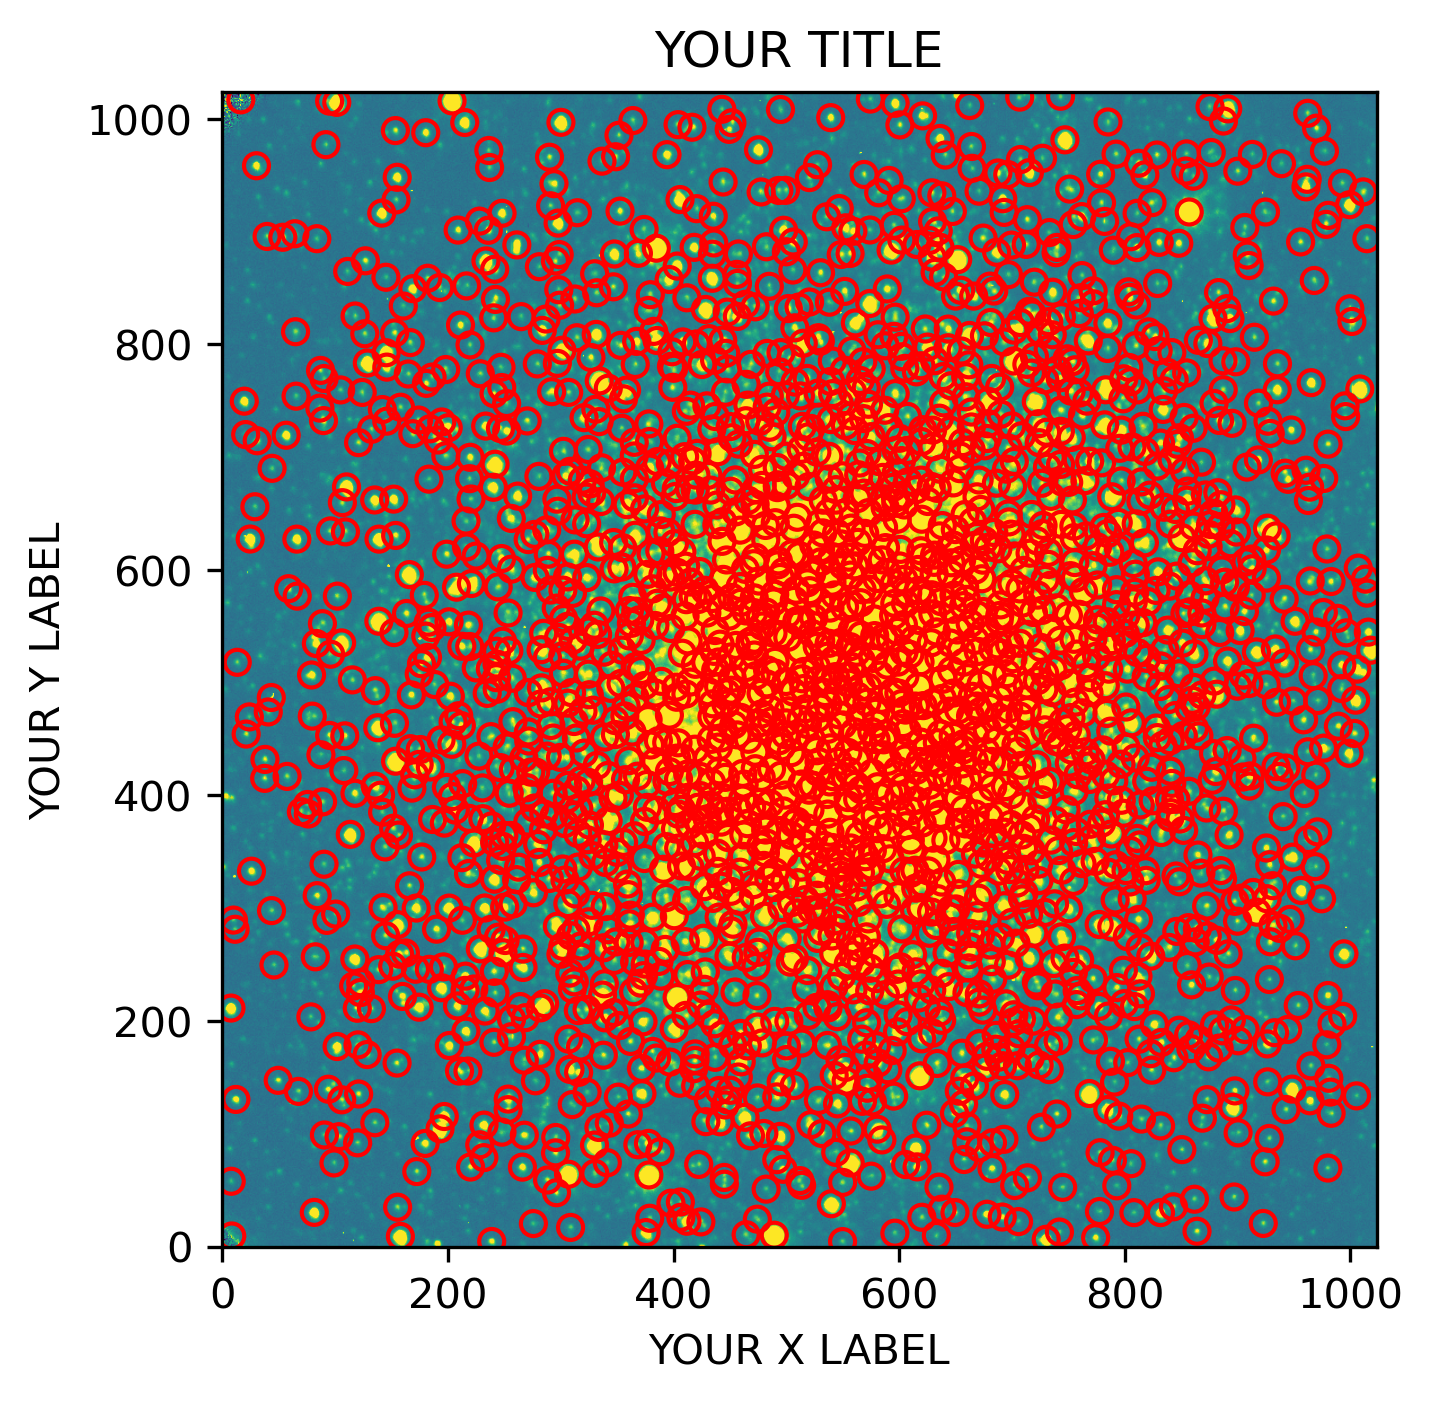

In [119]:
fig, ax = plt.subplots(figsize=(5,5), dpi=300)
ax.imshow(vdata, origin='lower', vmin=0, vmax=1000)
ax.scatter(sourcesv['xcentroid'], sourcesv['ycentroid'], facecolors='none', edgecolors='r')
ax.set_xlabel('YOUR X LABEL')
ax.set_ylabel('YOUR Y LABEL')
ax.set_title('YOUR TITLE')

plt.show()

### Now use your detection list to find same sources in your other filter
Having gotten detections in the V band, we need to match these to detection in the other filter we have, I. Input your file below. We will use the coordiates of detections in the V band and look for sources in the I filter image at the same location. As a note, we may not find as many sources because of the threshold considerations. 

Again, adjust the fwhm and threshold to see how many detections you can get. Aim for around 1,000.


In [120]:
# Find sources in i-image 

Idata = fits.getdata('./data/science/d86_os_bs_ff_bp.fits') # put your I filter image here
mean, median, std = sigma_clipped_stats(Idata, sigma=5.0)

# xy coordinates of detections in the V-band that we will give DAOStarFinder
xycoords = np.array(list(zip(sourcesv['xcentroid'], sourcesv['ycentroid'])))

# Run source detection
daofind_i = DAOStarFinder(fwhm=8, threshold=1*std, xycoords=xycoords) # change these numbers 
sourcesi = daofind_i(Idata-median)  

# print out list of detections
for col in sourcesi.colnames:  
    if col not in ('id', 'npix'):
        sourcesi[col].info.format = '%.2f' 
sourcesi.pprint(max_width=76)  
sourcesi.add_index('id')

 id  xcentroid ycentroid sharpness roundness1 ... sky    peak    flux   mag 
---- --------- --------- --------- ---------- ... ---- -------- ------ -----
   1    238.76      3.39      0.66      -0.03 ... 0.00  1855.01   6.44 -2.02
   2    549.92      4.15      0.87       0.04 ... 0.00   753.40   2.28 -0.89
   3    730.88      6.38      0.75      -0.04 ... 0.00  8955.38  27.13 -3.58
   4    774.54      7.15      0.78      -0.09 ... 0.00  2605.82   7.85 -2.24
   5    157.77      8.50      0.76      -0.05 ... 0.00 56164.95 167.40 -5.56
   6    489.89      9.11      0.23      -0.11 ... 0.00 62441.51 207.00 -5.79
   7    633.07      9.07      0.37      -0.10 ... 0.00   297.57   1.82 -0.65
   8    464.95      9.58      0.60      -0.26 ... 0.00   665.45   2.17 -0.84
   9    596.64     11.16      0.72      -0.24 ... 0.00   580.50   2.20 -0.85
  10    375.47     12.28      0.74      -0.13 ... 0.00  5204.37  16.04 -3.01
 ...       ...       ...       ...        ... ...  ...      ...    ...   ...

### Again, check location of sources on I-band image. Does it look like we are finding real sources?
If you are getting very few sources or obvious wrong detections, play around with the parameters above again.

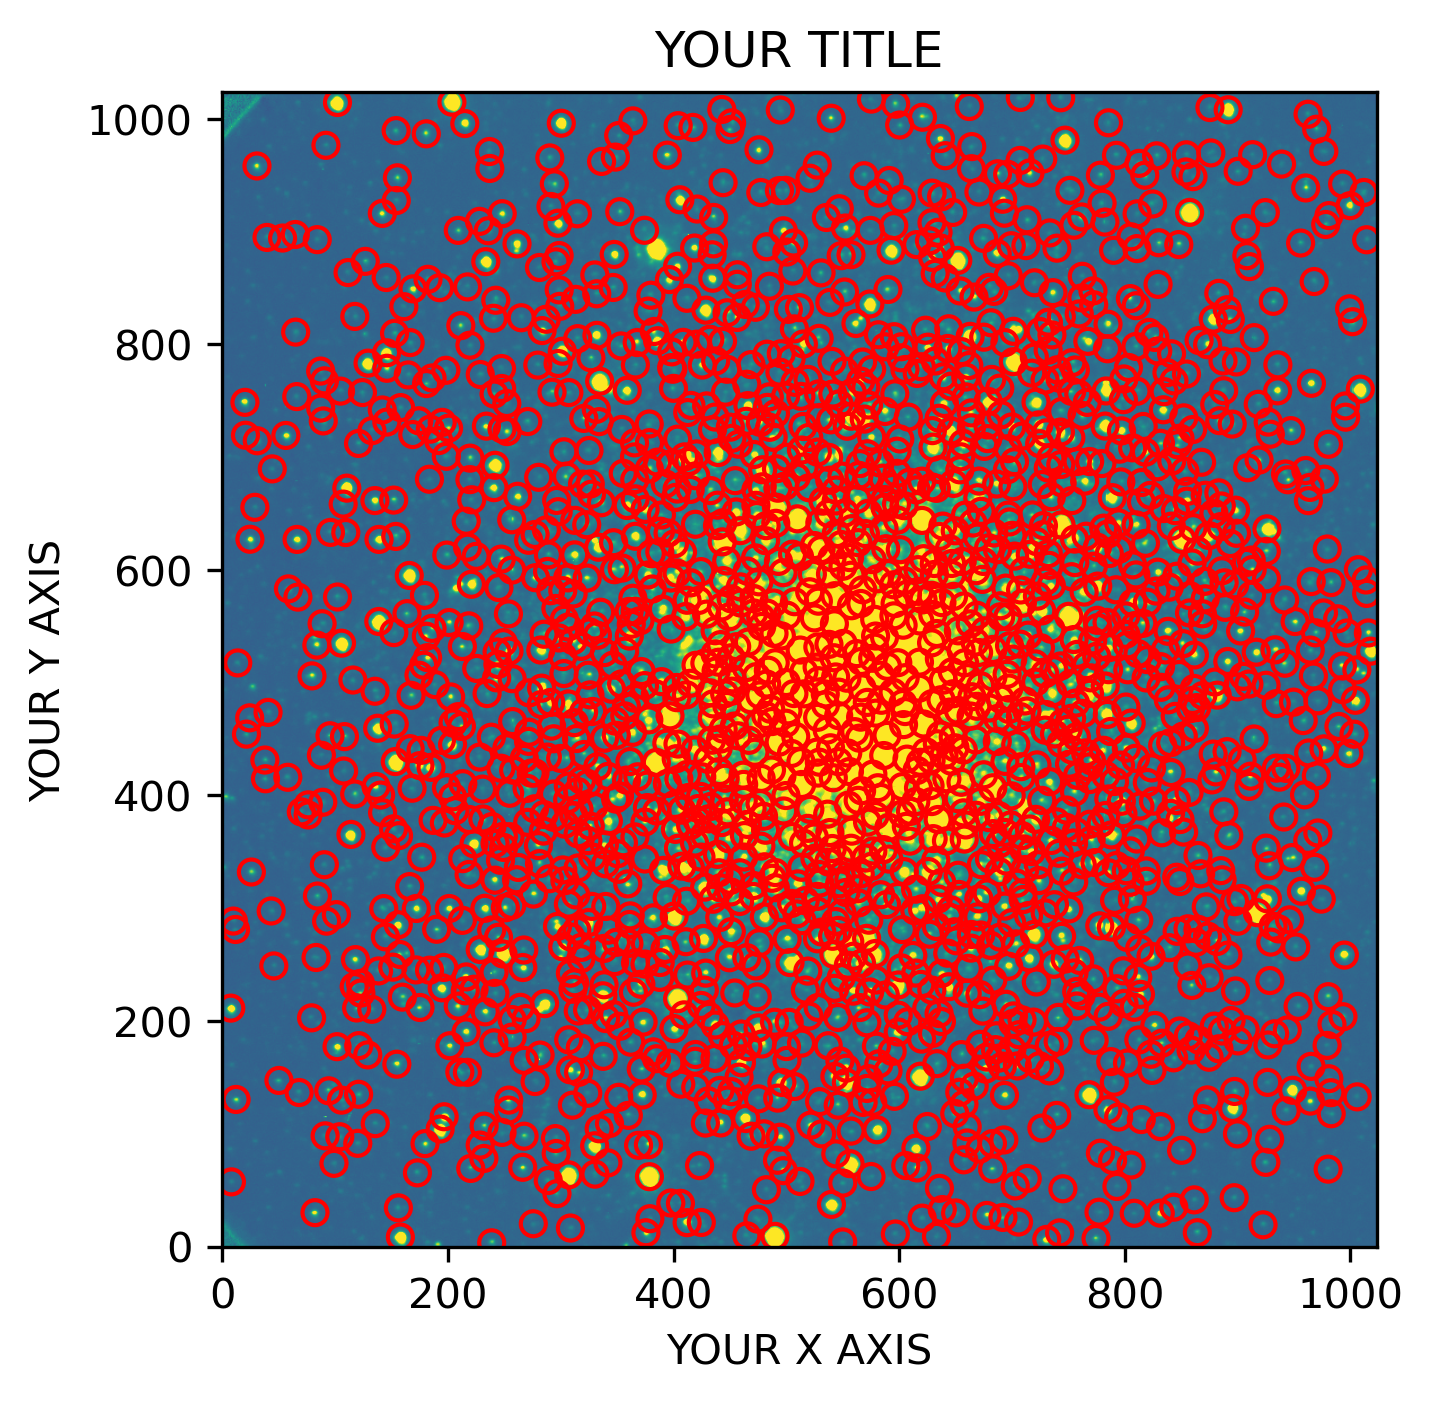

In [121]:
# check location on image

fig, ax = plt.subplots(figsize=(5,5), dpi=300)
ax.imshow(Idata, origin='lower', vmin=0, vmax=5000)
ax.scatter(sourcesi['xcentroid'], sourcesi['ycentroid'], facecolors='none', edgecolors='r')
ax.set_xlabel('YOUR X AXIS')
ax.set_ylabel('YOUR Y AXIS')
ax.set_title('YOUR TITLE')

plt.show()

### Next, we have to match sources between the two detection lists
Not all of our sources are found in both filters. Therefore, we need to match between our list of stars for common matches to make our color-magnitude diagram. Run the cell below to match.

In [122]:
# match between the two starlists

matches = []
for row in sourcesi:
    # find nearest 
    nearest = np.min(np.abs((row['xcentroid'] - sourcesv['xcentroid'])))
    idx = np.where(np.abs((row['xcentroid'] - sourcesv['xcentroid'])) == nearest)[0][0]
    matches += [idx+1]

### 3. Plot in color-magnitude
Below you will plot your Color-Magnitude diagram. In this diagram, think about the following:
- On your diagram, where is the Main Sequence? 
- Which Main Sequence stars are bluer and more massive, and which stars are redder and less massive?
- Do you see the Main Sequence turnoff?

Run the below cell to calculate the color and magnitude of each of your sources

In [ ]:
color = sourcesi['mag']-sourcesv.loc[matches]['mag']
mag = sourcesv.loc[matches]['mag']

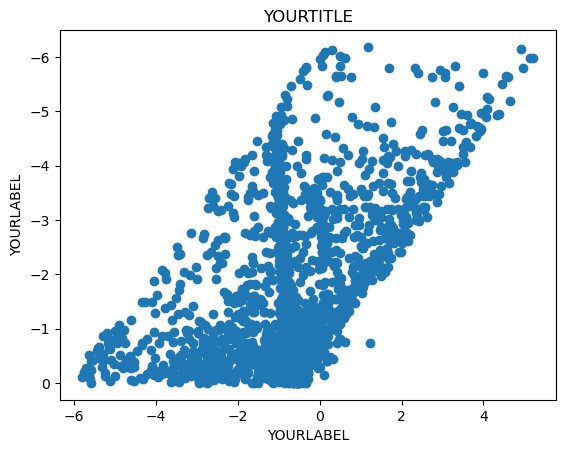

In [124]:
plt.scatter(YOURX, YOURY)
plt.gca().invert_yaxis()
plt.title('YOURTITLE')
plt.xlabel('YOURLABEL')
plt.ylabel('YOURLABEL')
plt.show()

## Estimating the mass at the main sequence turnoff of our cluster
Using the presense (or lack of a presense) of the turnoff, let's estimate the the most massive star in our cluster, and thus the mass of the turnoff stars. M92's age is around 14 billion years (if you choose a different, cluster look up it's age!)

The relationship between the Mass of a star ($M$) and its Main Sequence Lifetime $(t)$ is given by the following formula:

$t (\mathrm{yr}) \propto (4.5\times 10^9 ) M^{-2.5} $

Plug in this age estimate into the equation above. What is your estimated mass for your main sequence turnoff?